## Perceptron

> This notebook is a part of [AI for Beginners Curricula](http://github.com/microsoft/ai-for-beginners). Visit the repository for complete set of learning materials.

As we have discussed, perceptron allows you to solve **binary classification problem**, i.e. to classify input examples into two classes - we can call them **positive** and **negative**.

First, let's import some required libraries.

In [1]:
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os
import gzip

# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(1)
import random

## Toy Problem

To begin with, let's start with a toy problem, where we have two input features. For example, in medicine we may want to classify tumours into benign and malignant, depending on its size and age.

We will generate a random classification dataset using `make_classification` function from SciKit Learn library:

In [2]:
n = 50
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0)
Y = Y*2-1 # convert initial 0/1 values into -1/1
X = X.astype(np.float32); Y = Y.astype(np.int32) # features - float, label - int

# Split the dataset into training and test
train_x, test_x = np.split(X, [ n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])
print("Features:\n",train_x[0:4])
print("Labels:\n",train_labels[0:4])

Features:
 [[-1.7441838  -1.3952037 ]
 [ 2.5921783  -0.08124504]
 [ 0.9218062   0.91789985]
 [-0.8437018  -0.18738253]]
Labels:
 [-1 -1  1 -1]


Let's also plot the dataset:

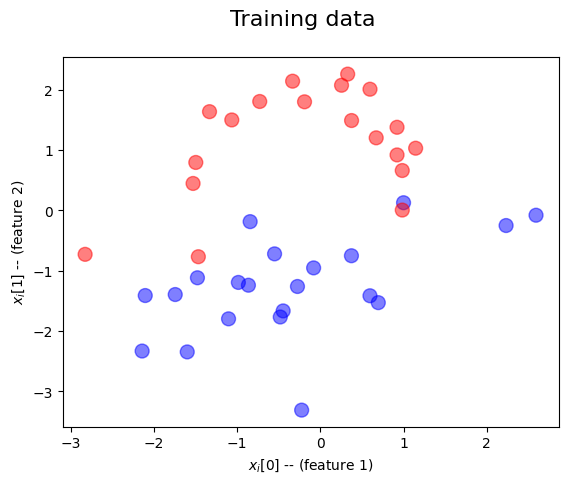

In [3]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = pylab.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l>0 else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

plot_dataset('Training data', train_x, train_labels)

## Perceptron

Since perceptron is a binary classifier, for each input vector $x$ the output of our perceptron would be either +1 or -1, depending on the class. The output will be computed using the formula

$$y(\mathbf{x}) = f(\mathbf{w}^{\mathrm{T}}\mathbf{x})$$

where $\mathbf{w}$ is a weight vector, $f$ is a step activation function:
$$
f(x) = \begin{cases}
         +1 & x \geq 0 \\
         -1 & x < 0
       \end{cases} \\
$$

However, a generic linear model should also have a bias, i.e. ideally we should compute $y$ as $y=f(\mathbf{w}^{\mathrm{T}}\mathbf{x}+\mathbf{b})$. To simplify our model, we can get rid of this bias term by adding one more dimension to our input features, which always equals to 1:

In [4]:
pos_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]>0])
neg_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]<0])
print(pos_examples[0:3])

[[ 0.92180622  0.91789985  1.        ]
 [-1.06435513  1.49764717  1.        ]
 [ 0.32839951  2.25677919  1.        ]]


## Training Algorithm

In order to train the perceptron, we need to find out weights $\mathbf{w}$ that will minimize the error. The error is defined using **perceptron criteria**:

$$E(\mathbf{w}) = -\sum_{n \in \mathcal{M}}\mathbf{w}^{\mathrm{T}}\mathbf{x}_{n}t_{n}$$
 
  * $t_{n} \in \{-1, +1\}$ for negative and positive training samples, respectively
  * $\mathcal{M}$ - a set of wrongly classified examples
  
We will use the process of **gradient descent**. Starting with some initial random weights $\mathbf{w}^{(0)}$, we will adjust weights on each step of the training using the gradient of $E$:

$$\mathbf{w}^{\tau + 1}=\mathbf{w}^{\tau} - \eta \nabla E(\mathbf{w}) = \mathbf{w}^{\tau} + \eta\sum_{n \in \mathcal{M}}\mathbf{x}_{n} t_{n}$$

where $\eta$ is a **learning rate**, and $\tau\in\mathbb{N}$ - number of iteration.

Let's define this algorithm in Python:

In [5]:
def train(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    
    # Initialize weights. 
    # We initialize with 0 for simplicity, but random initialization is also a good idea
    weights = np.zeros((num_dims,1)) 
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 10
    
    for i in range(num_iterations):
        # Pick one positive and one negative example
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0: # positive example was classified as negative
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0: # negative example was classified as positive
            weights = weights - neg.reshape(weights.shape)
            
        # Periodically, print out the current accuracy on all examples 
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Iteration={}, pos correct={}, neg correct={}".format(i,pos_correct,neg_correct))

    return weights

Now let's run the training on our dataset:

In [6]:
wts = train(pos_examples,neg_examples)
print(wts.transpose())

Iteration=0, pos correct=0.6842105263157895, neg correct=0.8571428571428571
Iteration=10, pos correct=0.8947368421052632, neg correct=0.9523809523809523
Iteration=20, pos correct=0.8421052631578947, neg correct=0.8095238095238095
Iteration=30, pos correct=0.8947368421052632, neg correct=0.8571428571428571
Iteration=40, pos correct=0.8947368421052632, neg correct=0.8571428571428571
Iteration=50, pos correct=0.8947368421052632, neg correct=0.9523809523809523
Iteration=60, pos correct=0.8947368421052632, neg correct=0.9523809523809523
Iteration=70, pos correct=0.8947368421052632, neg correct=0.8571428571428571
Iteration=80, pos correct=0.8947368421052632, neg correct=0.9523809523809523
Iteration=90, pos correct=0.9473684210526315, neg correct=0.8095238095238095
[[-3.09552228  3.8741692   1.        ]]


As you can see, initial accuracy is around 50%, but it quickly increases to higher values close to 90%.

Let's visualize how classes are separated. Our classification function looks like $\mathbf{w}^Tx$, and it is greater than 0 for one class, and is below 0 for another. Thus, class separation line is defined by $\mathbf{w}^Tx = 0$. Since we have only two dimensions $x_0$ and $x_1$, the equation for the line would be $w_0x_0+w_1x_1+w_2 = 0$ (remember that we have explicitly defined an extra dimension $x_2=1$). Let's plot this line:

In [7]:
def plot_boundary(positive_examples, negative_examples, weights):
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([-6, 6], dtype = 'float32')
        else:
            y = np.array([-6, 6], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([-6, 6], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]

    pylab.xlim(-6, 6)
    pylab.ylim(-6, 6)                      
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()

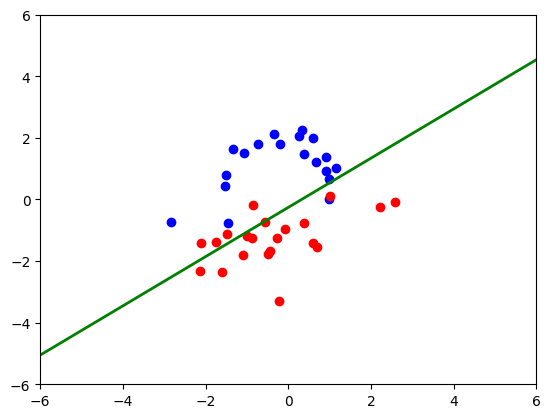

In [8]:
plot_boundary(pos_examples,neg_examples,wts)

## Evaluate on Test Dataset

In the beginning, we have put apart some data to the test dataset. Let's see how accurate our classifier is on this test dataset. In order to do this, we also expand the test dataset with an extra dimension, multiply by weights matrix, and make sure that the obtained value is of the same sign as the label (+1 or -1). We then add together all boolean values and divide by the length of test sample, to obtain the accuracy:

In [9]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

accuracy(wts, test_x, test_labels)

0.9

## Observing the training process

We have seen before how the accuracy decreases during training. It would be nice to see how the separation line behaves during training. The code below will visualize everything on one graph, and you should be able to move the slider to "time-travel" through the training process. 

In [10]:
def train_graph(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    weights = np.zeros((num_dims,1)) # initialize weights
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 15;
    snapshots = []
    
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)
            
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            # make correction a list so it is homogeneous to weights list then numpy array accepts
            snapshots.append((np.concatenate(weights),[(pos_correct+neg_correct)/2.0,0,0]))

    # ORIGINAL CODE
    # return np.array(snapshots)
 
    # KALEB CODE - original did not work with updated numpy
    return np.asarray(snapshots, dtype="object")


snapshots = train_graph(pos_examples,neg_examples)

def plotit(pos_examples,neg_examples,snapshots,step):
    fig = pylab.figure(figsize=(10,4))
    fig.add_subplot(1, 2, 1)
    plot_boundary(pos_examples, neg_examples, snapshots[step][0])
    fig.add_subplot(1, 2, 2)
    pylab.plot(np.arange(len(snapshots[:,1])), snapshots[:,1])
    pylab.ylabel('Accuracy')
    pylab.xlabel('Iteration')
    pylab.plot(step, snapshots[step,1][0], "bo")
    pylab.show()
def pl1(step): plotit(pos_examples,neg_examples,snapshots,step)

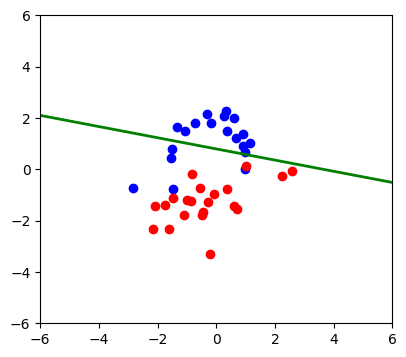

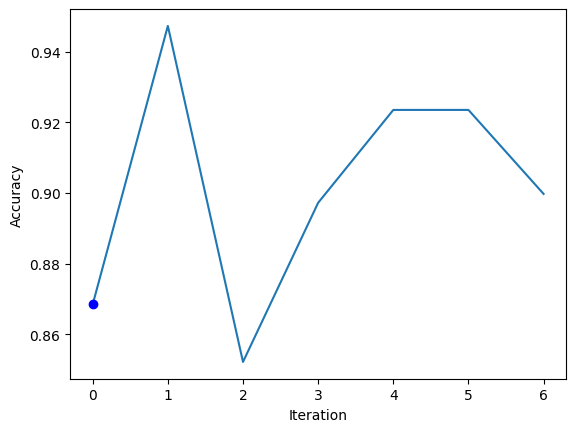

<function __main__.pl1(step)>

In [11]:
interact(pl1, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

## Limitations of the Perceptron

As you have seen above, perceptron is a **linear classifier**. It can distinguish between two classes well if they are **linearly separable**, i.e. can be separated by a straight line. Otherwise, perceptron training process will not converge.

A most obvious example of a problem that cannot be solved by a perceptron is so-called **XOR problem**. We want our perceptron to learn the XOR boolean function, which has the following truth table:

|   | 0 | 1 |
|---|---|---|
| 0 | 0 | 1 | 
| 1 | 1 | 0 |

Let's try and do that! We will manually populate all positive and negative training samples, and then call our train function defined above:

In [12]:
pos_examples_xor = np.array([[1,0,1],[0,1,1]])
neg_examples_xor = np.array([[1,1,1],[0,0,1]])

snapshots_xor = train_graph(pos_examples_xor,neg_examples_xor,1000)
def pl2(step): plotit(pos_examples_xor,neg_examples_xor,snapshots_xor,step)

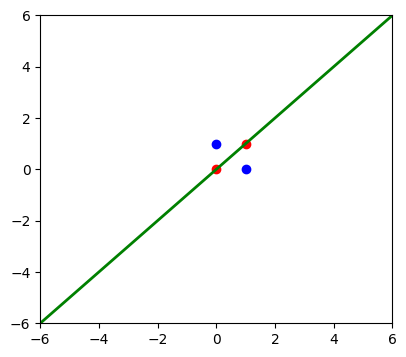

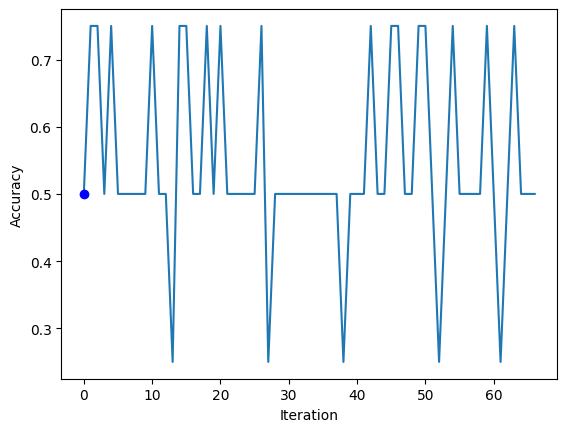

<function __main__.pl2(step)>

In [13]:
interact(pl2, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

As you can see from the graph above, the accuracy never goes above 75%, because it is impossible to draw a straight line in such a way as to get all possible examples right.

The XOR problem is a classical example of perceptron limitations, and it was pointed out by Marvin Minsky and Seymour Papert in 1969 in their book [Perceptrons](https://en.wikipedia.org/wiki/Perceptrons_(book)). This observation limited research in the area of neural networks for almost 10 years, even though - and we will see this in the next section of our course - multi-layered perceptrons are perfectly capable of solving such problems.

## Complex Example - MNIST

Even though perceptron cannot solve XOR problem, it can solve many more complex problems, such as handwritten character recognition.

A dataset that is often used when mastering machine learning is called [MNIST](https://en.wikipedia.org/wiki/MNIST_database). It has been created by Modified National Institute of Standards and Technology, and contains a training set of 60000 handwritten digits, collected from around 250 students and employees of the institute. There is also a test dataset of 10000 digits, collected from different individuals.

All digits are represented by grayscale images of size 28x28 pixels.

> MNIST Dataset is available as a training competition on [Kaggle](https://www.kaggle.com/c/digit-recognizer), a site that hosts machine learning competitions and contests. Once you learn how to classify MNIST digits, you can submit your solution to Kaggle to see how it is rated among other participants. 

We start by loading MNIST dataset:

In [20]:
# If you are not running this notebook from a cloned repository, you may need to grab the binary dataset file first
# !wget https://github.com/microsoft/AI-For-Beginners/blob/main/data/mnist.pkl.gz?raw=true
# In this case correct the link to the dataset below as well.

with gzip.open('../../data/mnist.pkl.gz', 'rb') as mnist_pickle:
    # ORIGINAL CODE (NOT WORKING) 
    # MNIST = pickle.load(mnist_pickle)
    # KALEB CODE
    MNIST = pickle.load(mnist_pickle, encoding='latin1')

Let's now plot the dataset:

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01171875 0.0703125
 0.0703125  0.0703125  0.4921875  0.53125    0.68359375 0.1015625
 0.6484375  0.99609375 0.96484375 0.49609375 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.1171875  0.140625
 0.3671875  0.6015625 ]
5


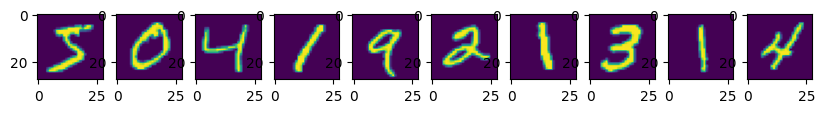

In [25]:

# OLD CODE (we don't have access to the original data
# print(MNIST['Train']['Features'][0][130:180])
# print(MNIST['Train']['Labels'][0])
# features = MNIST['Train']['Features'].astype(np.float32) / 256.0
# labels = MNIST['Train']['Labels']
# fig = pylab.figure(figsize=(10,5))
# for i in range(10):
#     ax = fig.add_subplot(1,10,i+1)
#     pylab.imshow(features[i].reshape(28,28))
# pylab.show()

# KALEB (technically GanGral's from the issues topic on this) CODE
# Train = 0; Features = 0 || Labels = 1
print(MNIST[0][0][0][130:180])
print(MNIST[0][1][0])
features = MNIST[0][0].astype(np.float32) / 256.0
labels = MNIST[0][1]
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(features[i].reshape(28,28))
pylab.show()

Because perceptron is a binary classifier, we will limit our problem to recognizing only two digits. The function below will populate positive and negative sample arrays with two given digits (and will also show samples of those digits for clarity).

In [43]:
def set_mnist_pos_neg(positive_label, negative_label):
    # KALEB CODE
    # Train = 0; Features = 0 || Labels = 1
    
    # OLD CODE
    # positive_indices = [i for i, j in enumerate(MNIST['Train']['Labels']) 
    # negative_indices = [i for i, j in enumerate(MNIST['Train']['Labels']) 

    # KALEB CODE
    positive_indices = [i for i, j in enumerate(MNIST[0][1])
                          if j == positive_label]
    negative_indices = [i for i, j in enumerate(MNIST[0][1])
                          if j == negative_label]

    # OlD CODE
    # positive_images = MNIST['Train']['Features'][positive_indices]
    # negative_images = MNIST['Train']['Features'][negative_indices]

    # KALEB CODE
    positive_images = MNIST[0][0][positive_indices]
    negative_images = MNIST[0][0][negative_indices]

    fig = pylab.figure()
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(positive_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    pylab.imshow(negative_images[0].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.show()
    
    return positive_images, negative_images

We will start by trying to classify between 0 and 1:

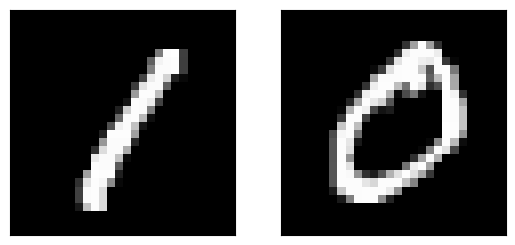

In [44]:
pos1,neg1 = set_mnist_pos_neg(1,0)

In [45]:
def plotit2(snapshots_mn,step):
    fig = pylab.figure(figsize=(10,4))
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(snapshots_mn[step][0].reshape(28, 28), interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.colorbar()
    ax = fig.add_subplot(1, 2, 2)
    ax.set_ylim([0,1])
    pylab.plot(np.arange(len(snapshots_mn[:,1])), snapshots_mn[:,1])
    pylab.plot(step, snapshots_mn[step,1], "bo")
    pylab.show()
def pl3(step): plotit2(snapshots_mn,step)
def pl4(step): plotit2(snapshots_mn2,step)    

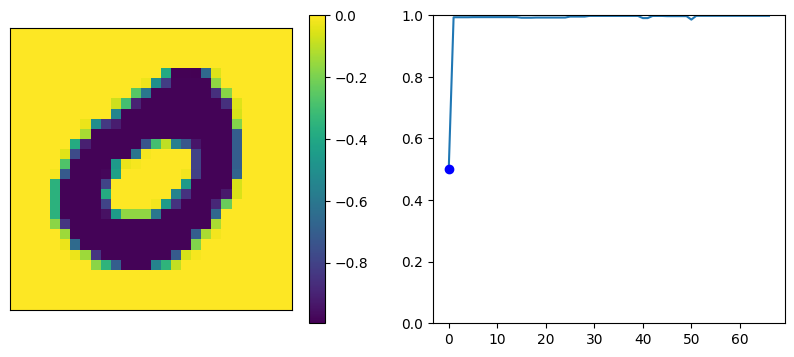

<function __main__.pl3(step)>

In [34]:
snapshots_mn = train_graph(pos1,neg1,1000)    
interact(pl3, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn) - 1))

Please note how accuracy goes up to almost 100% very fast.

Please, move the slider to some position towards the end of the training, and observe the weight matrix plotted on the left. This matrix will allow you to understand how perceptron actually works. You can see the high weight values in the middle of the field, which correspond to pixels that are typically present for digit 1, and low negative values by the sides, where parts of 0 digit are. So, if the digit presented to the perceptron is in fact 1, middle part of it will be mupliplied by high values, producing positive result. On the contrary, when perceptron observes 0, corresponding pixels will be multiplied by negative numbers.

> You may notice that if we give our perceptron a digit 1 slightly shifted horizontally, so that its pixels occupy the place where there are vertical parts of 0, we may receive incorrect result. Since the nature of our MNIST dataset is such that all digits are centered and positioned properly, and perceptron relies on this to distinguish between digits.

Now let's try different digits: 

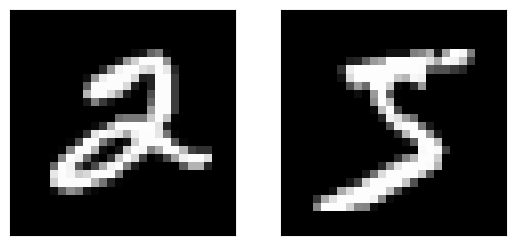

In [35]:
pos2,neg2 = set_mnist_pos_neg(2,5)

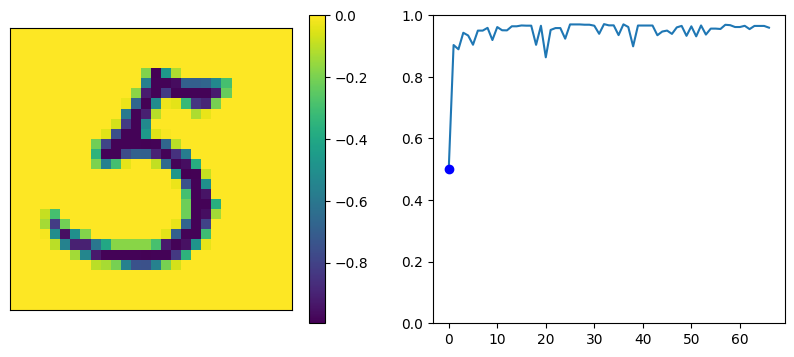

<function __main__.pl4(step)>

In [36]:
snapshots_mn2 = train_graph(pos2,neg2,1000)
interact(pl4, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn2) - 1))

## Discussion

For some reason, 2 and 5 are not as easily separable. Even though we get relatively high accuracy (above 85%), we can clearly see how perceptron stops learning at some point.

To understand why this happens, we can try to use [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA). It is a machine learning technique used to lower the dimensionality of the input dataset, in such a way as to obtain the best separability between classes. 

In our case, an input image has 784 pixels (input features), and we want to use PCA to reduce the number of parameter to just 2, so that we can plot them on the graph. Those two parameters would be a linear combination of original features, and we can view this procedure as "rotating" our original 784-dimensional space and observing it's projection to our 2D-space, until we get the best view that separates the classes.

In [38]:
from sklearn.decomposition import PCA

def pca_analysis(positive_label, negative_label):
    positive_images, negative_images = set_mnist_pos_neg(positive_label, negative_label)
    M = np.append(positive_images, negative_images, 0)

    mypca = PCA(n_components=2)
    mypca.fit(M)
    
    pos_points = mypca.transform(positive_images[:200])
    neg_points = mypca.transform(negative_images[:200])

    pylab.plot(pos_points[:,0], pos_points[:,1], 'bo')
    pylab.plot(neg_points[:,0], neg_points[:,1], 'ro')

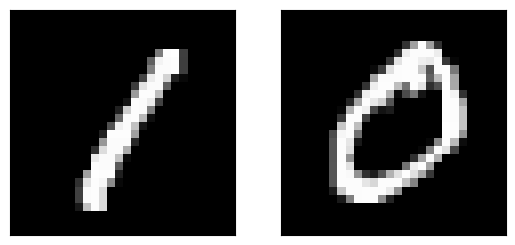

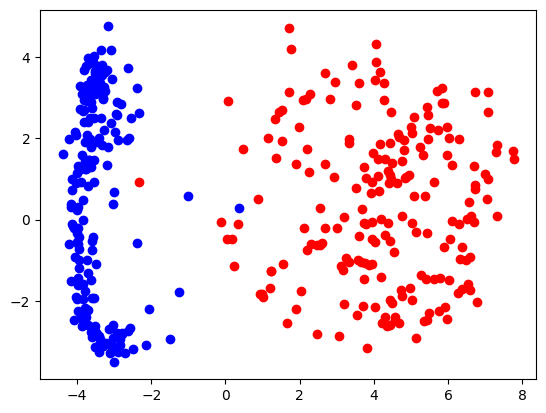

In [39]:
pca_analysis(1,0)

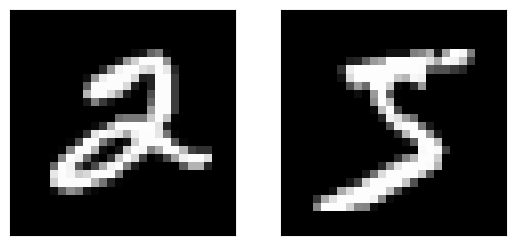

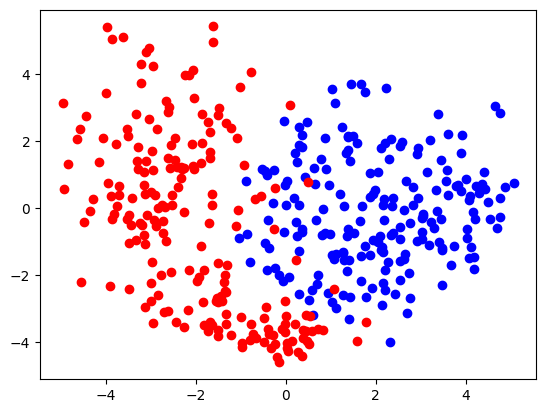

In [40]:
pca_analysis(2,5)

As you can see, 0 and 1 can be clearly separated by a straight line. This indicates that in the original 784-dimensional space dots corresponding to digits are also linearly separable. In the case of 2 and 5, we cannot find the good projection that will separate the digits clearly, and thus there are some cases of wrong classification.

> Later on this course we will learn how to create non-linear classifiers using Neural Networks, and how to deal with a problem of digits not being properly aligned. Very soon we will reach above 99% accuracy in MNIST digit classification, while classifying them into 10 different classes.

## Takeaway

 * We have leart about the simplest neural network architecture - one-layer perceptron.
 * We have implemented the perceptron "by hand", using simple training procedure based on gradient descent
 * Despite simplicity, one-layered perceptron can solve rather complex problems of handwritten digit recognition
 * One-layered perceptron is a liner classifier, and thus it provides the same classification power as logistic regression.
 * In the sample space, perceptron can separate two classes of input data using hyperplane.

## Credits

This notebook is a part of [AI for Beginners Curricula](http://github.com/microsoft/ai-for-beginners), and has been prepared by [Dmitry Soshnikov](http://soshnikov.com). It is inspired by Neural Network Workshop at Microsoft Research Cambridge. Some code and illustrative materials are taken from presentations by [Katja Hoffmann](https://www.microsoft.com/en-us/research/people/kahofman/), [Matthew Johnson](https://www.microsoft.com/en-us/research/people/matjoh/) and [Ryoto Tomioka](https://www.microsoft.com/en-us/research/people/ryoto/), and from [NeuroWorkshop](http://github.com/shwars/NeuroWorkshop) repository.